## Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from scipy import stats

## Ladda och Förbered Data

In [9]:
df = pd.read_csv("housing.csv")

# Rensa null-värden
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

# Log-transformation av målvariabel
df['median_house_value'] = np.log1p(df['median_house_value'])

# Skapa nya funktioner
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

# Ändra ocean_proximity till kategorier
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

# Definiera X och y
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

## Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Träna och Utvärdera XGBoost-Modellen

In [11]:
# Skala funktionerna
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Skapa och träna en XGBoost-modell
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
# Utvärdera XGBoost-modellen
y_pred_xgb = xgb_reg.predict(X_test_scaled)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost RMSE: ", xgb_rmse)
print("R²-värde:", xgb_r2)

XGBoost RMSE:  0.830787527323336
R²-värde: -1.126586932623264


## Hyperparameteroptimering

In [14]:
# Hyperparameter tuning med GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Hitta de bästa parametervärdena
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Använd de bästa parametervärdena för att träna en ny XGBoost-modell
best_xgb = XGBRegressor(**best_params)
best_xgb.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# Utvärdera den bästa XGBoost-modellen
y_pred_best_xgb = best_xgb.predict(X_test_scaled)
best_xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
best_xgb_r2 = r2_score(y_test, y_pred_best_xgb)

print("Best XGBoost RMSE: ", best_xgb_rmse)
print("Best XGBoost R²-värde:", best_xgb_r2)

Best XGBoost RMSE:  0.21812665488999147
Best XGBoost R²-värde: 0.8534044849276076


## Validering

In [16]:
# Korskontroll för validering
scores = cross_val_score(best_xgb, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)

print("Cross-Validation RMSE Scores:", rmse_scores)
print("Average Cross-Validation RMSE:", rmse_scores.mean())

Cross-Validation RMSE Scores: [0.22097818 0.21308305 0.21779896 0.2223878  0.21650939]
Average Cross-Validation RMSE: 0.21815147569449628


## Visualisera Modellens Prestanda

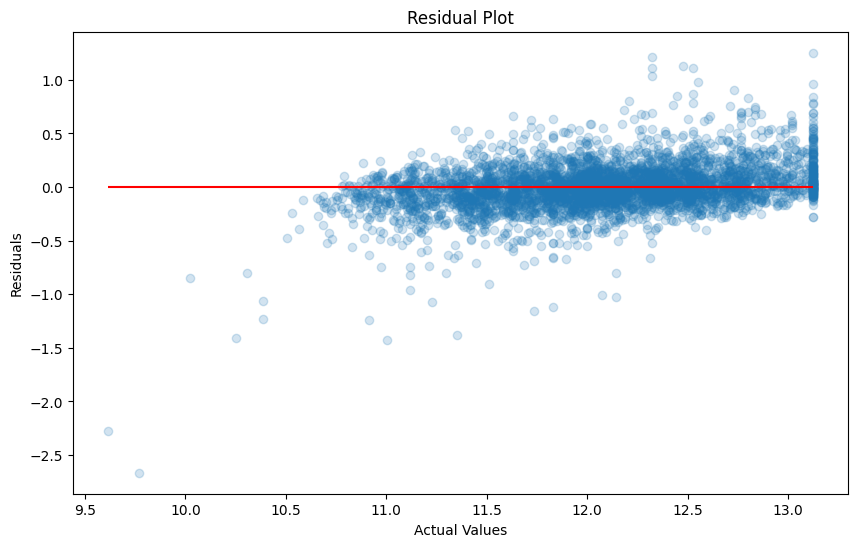

In [17]:
# Residual Plot
residuals = y_test - y_pred_best_xgb
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.2)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='r')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.show()

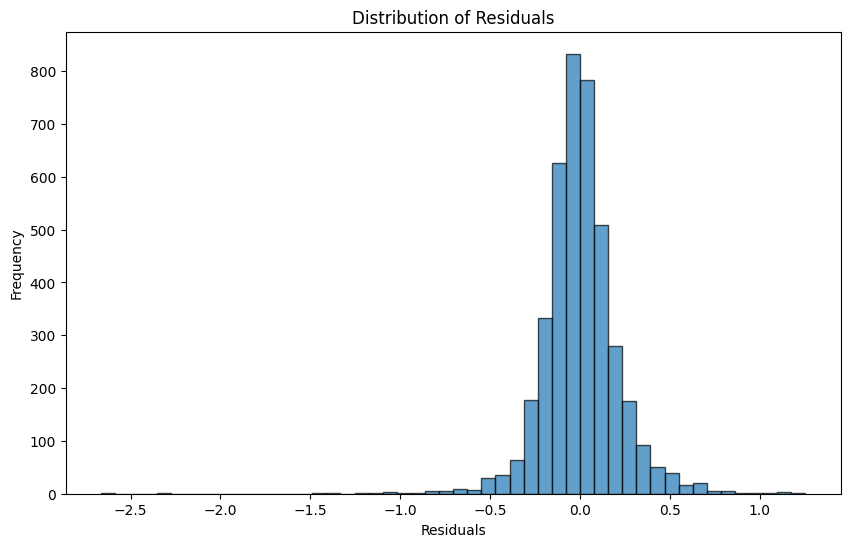

In [18]:
# Distribution of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.show()

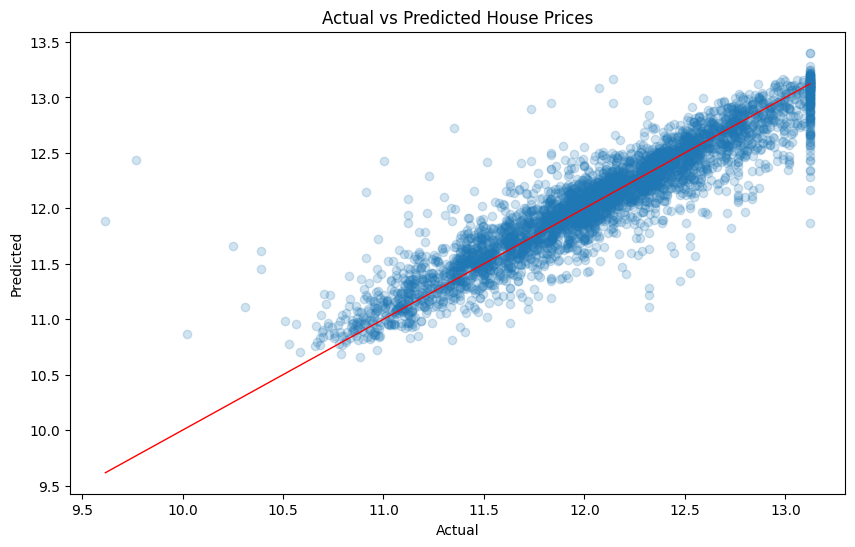

In [19]:
# Plot the actual vs predicted house prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_xgb, alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted House Prices')

plt.show()